# trains a CrossEncoder for the classification task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd drive/MyDrive/sna/

/content/drive/MyDrive/sna


In [3]:
! pip install -U -q sentence-transformers
! pip install -q transformers

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 4.0 MB 35.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.9 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.2 MB/s 
     |████████████████████████████████| 596 kB 69.2 MB/s 
     |████████████████████████████████| 895 kB 70.4 MB/s 


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 27 04:34:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
from torch.utils.data import DataLoader
import math
import torch
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

In [7]:
product = pd.read_csv('data/product_catalogue-v0.2.csv', dtype="string")
train = pd.read_csv("data/train-v0.2.csv", dtype="string")
test = pd.read_csv("data/test_public-v0.2.csv", dtype="string")

In [8]:
# Join product dataset with train dataset on product id
alled = train.merge(product, on="product_id", how="inner", validate="many_to_many")
alled = alled.fillna("")

In [9]:
alled['pro_all'] = alled['product_title'] + ". " +alled['product_brand']+ ". " + alled['product_color_name'] + ". " + alled["product_bullet_point"] + ". " + alled['product_description'] + "."
alled['pro_all'].head(20)

0     American Lawn Mower Company 1204-14 14-Inch 4-...
1     American Lawn Mower Company 1204-14 14-Inch 4-...
2     American Lawn Mower Company 1204-14 14-Inch 4-...
3     American Lawn Mower Company 1204-14 14-Inch 4-...
4     Oregon 72-107 Universal Wheel 7X150 Diamond Pl...
5     Oregon 72-107 Universal Wheel 7X150 Diamond Pl...
6     Oregon 72-107 Universal Wheel 7X150 Diamond Pl...
7     Carlisle Turf Saver Lawn & Garden Tire - 15X6-...
8     Carlisle Turf Saver Lawn & Garden Tire - 15X6-...
9     Honda 44710-VG3-010 Front Wheels, (Set of 2). ...
10    Honda 42710-VE2-M02ZE (Replaces 42710-VE2-M01Z...
11    Honda HRR Wheel Kit (2 Front 44710-VL0-L02ZB, ...
12    15x6.00-6" Front Tire Assembly Replacement for...
13    15x6.00-6" Front Tire Assembly Replacement for...
14    Craftsman 532403111 Mower Front Drive Wheels (...
15    Dr.Roc Tire Spoon Lever Dirt Bike Lawn Mower M...
16    MARASTAR 21446-2PK 15x6.00-6" Front Tire Assem...
17    RamPro 10" All Purpose Utility Air Tires/W

In [10]:
alled['esci_label'].unique()

<StringArray>
['irrelevant', 'exact', 'substitute', 'complement']
Length: 4, dtype: string

In [16]:
# Read the AllNLI.tsv.gz file and create the training dataset
logger.info("Read AllNLI train dataset")

train_count = 571223
train_flag = True
dev_count = 10000
dev_flag = True
test_count = 79337
test_flag = True
frac_train = 0.9
frac_test = 0.8

from sklearn.model_selection import train_test_split

train_all, test = train_test_split(alled, train_size=frac_train, shuffle=True)
train, dev = train_test_split(train_all, train_size=frac_test, shuffle=True)
print('Before training shape:',train.shape)
print('Before dev shape:',dev.shape)
print('Before test shape:',test.shape)

train = train.sample(n=train_count)
dev = dev.sample(n=dev_count)
test = test.sample(n=test_count)

print('After training shape:',train.shape)
print('After dev shape:',dev.shape)
print('After test shape:',test.shape)

train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

label2int = {"exact": 0, "substitute": 1, "complement": 2, "irrelevant": 3}
train_samples = []
dev_samples = []
test_samples = []

for i in range(train.shape[0]):
  train_samples.append(InputExample(texts=[train.at[i, 'query'], train.at[i, 'pro_all']], label=label2int[train.at[i, 'esci_label']]))

for i in range(dev.shape[0]):
  dev_samples.append(InputExample(texts=[dev.at[i, 'query'], dev.at[i, 'pro_all']], label=label2int[dev.at[i, 'esci_label']]))

for i in range(test.shape[0]):
  test_samples.append(InputExample(texts=[test.at[i, 'query'], test.at[i, 'pro_all']], label=label2int[test.at[i, 'esci_label']]))

2022-04-27 04:38:45 - Read AllNLI train dataset
Before training shape: (571223, 12)
Before dev shape: (142806, 12)
Before test shape: (79337, 12)
After training shape: (571223, 12)
After dev shape: (10000, 12)
After test shape: (79337, 12)


In [17]:
train_batch_size = 16
num_epochs = 2
model_save_path = 'output/training_allnli-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
modelname = 'distilbert-base-uncased'

#Define our CrossEncoder model. We use distilroberta-base as basis and setup it up to predict 3 labels
model = CrossEncoder(model_name=modelname, num_labels=len(label2int))

#We wrap train_samples, which is a list ot InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

#During training, we use CESoftmaxAccuracyEvaluator to measure the accuracy on the dev set.
evaluator = CESoftmaxAccuracyEvaluator.from_input_examples(dev_samples, name='dev')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

2022-04-27 04:39:14 - Use pytorch device: cuda


In [20]:
print(model_save_path)

output/training_allnli-2022-04-27_04-39-11


In [18]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))

import time
start = time.time()

# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          optimizer_class = torch.optim.Adam,
          evaluation_steps=100,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

end = time.time()
print((end - start)/60)

2022-04-27 04:39:25 - Warmup-steps: 7141


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/35702 [00:00<?, ?it/s]

2022-04-27 04:40:08 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 0 after 100 steps:
2022-04-27 04:41:29 - Accuracy: 27.87
2022-04-27 04:41:29 - Save model to output/training_allnli-2022-04-27_04-39-11
2022-04-27 04:42:12 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 0 after 200 steps:
2022-04-27 04:43:32 - Accuracy: 32.88
2022-04-27 04:43:32 - Save model to output/training_allnli-2022-04-27_04-39-11
2022-04-27 04:44:16 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 0 after 300 steps:
2022-04-27 04:45:36 - Accuracy: 33.68
2022-04-27 04:45:36 - Save model to output/training_allnli-2022-04-27_04-39-11
2022-04-27 04:46:20 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 0 after 400 steps:
2022-04-27 04:47:40 - Accuracy: 33.71
2022-04-27 04:47:40 - Save model to output/training_allnli-2022-04-27_04-39-11
2022-04-27 04:48:24 - CESoftmaxAccuracyEvaluator: Evaluating the model on de

Iteration:   0%|          | 0/35702 [00:00<?, ?it/s]

2022-04-27 16:50:22 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 100 steps:
2022-04-27 16:51:42 - Accuracy: 43.90
2022-04-27 16:52:24 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 200 steps:
2022-04-27 16:53:44 - Accuracy: 43.90
2022-04-27 16:54:27 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 300 steps:
2022-04-27 16:55:47 - Accuracy: 43.90
2022-04-27 16:56:29 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 400 steps:
2022-04-27 16:57:49 - Accuracy: 43.90
2022-04-27 16:58:32 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 500 steps:
2022-04-27 16:59:52 - Accuracy: 43.90
2022-04-27 17:00:34 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in epoch 1 after 600 steps:
2022-04-27 17:01:55 - Accuracy: 43.90
2022-04-27 17:02:37 - CESoftmaxAccuracyEvaluator: Evaluating the model on dev dataset in

KeyboardInterrupt: ignored

Batches:   0%|          | 0/2480 [00:00<?, ?it/s]

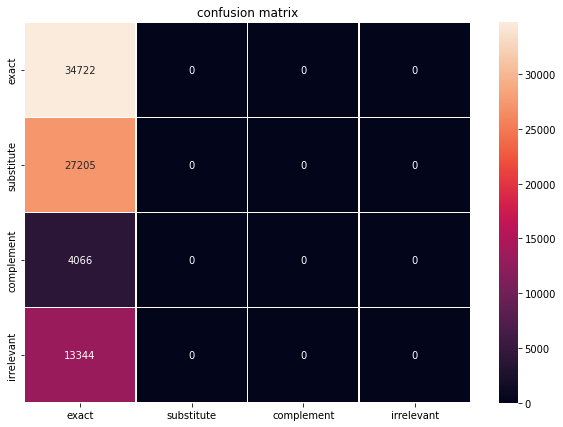

In [19]:
testor = CESoftmaxAccuracyEvaluator.from_input_examples(test_samples, name='test')

scores = model.predict(testor.sentence_pairs)
label_mapping = ["exact", "substitute", "complement", "irrelevant"]
pred_labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
true_lables = [label_mapping[i] for i in testor.labels]

from sklearn.metrics import confusion_matrix
import seaborn as sn

array = confusion_matrix(y_true=true_lables, y_pred=pred_labels, labels = label_mapping)

df_cm = pd.DataFrame(array, index = [i for i in label_mapping],
                  columns = [i for i in label_mapping])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
ax.set_title(f'confusion matrix')
plt.show()